In [1]:
import nltk
from nltk import FreqDist
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kartik.sonaghela\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_json('Automotive_5.json', lines=True)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3F73SC1LY51OO,B00002243X,Alan Montgomery,"[4, 4]",I needed a set of jumper cables for my new car and these had good reviews and were at a good price. They have been used a few times already and do what they are supposed to - no complaints there....,5,Work Well - Should Have Bought Longer Ones,1313539200,"08 17, 2011"
1,A20S66SKYXULG2,B00002243X,alphonse,"[1, 1]","These long cables work fine for my truck, but the quality seems a little on the shabby side. For the money I was not expecting 200 dollar snap-on jumper cables but these seem more like what you wo...",4,Okay long cables,1315094400,"09 4, 2011"
2,A2I8LFSN2IS5EO,B00002243X,Chris,"[0, 0]","Can't comment much on these since they have not yet been used (I will come back and update my review is I find any issues after first use) ... but they are built solid, nice tough big hard clamps ...",5,Looks and feels heavy Duty,1374710400,"07 25, 2013"
3,A3GT2EWQSO45ZG,B00002243X,DeusEx,"[19, 19]","I absolutley love Amazon!!! For the price of a set of cheap Booster/Jumper Cables in a brick and morter store, you can buy extra long and heavy duty jumpers! First off, don't be the person that ...",5,Excellent choice for Jumper Cables!!!,1292889600,"12 21, 2010"
4,A3ESWJPAVRPWB4,B00002243X,E. Hernandez,"[0, 0]","I purchased the 12' feet long cable set and they arrived in a retail cardboard box with handle, which could be used as a storage and carrying case for these cables, although I will not need to sto...",5,"Excellent, High Quality Starter Cables",1341360000,"07 4, 2012"


In [4]:
# function to plot most frequent terms
def freq_words(x, terms ):
    all_words = ' '.join([text for text in x])
    
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    # selecting top 30 most frequent words
    d = words_df.nlargest(columns="count", n = terms)
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()


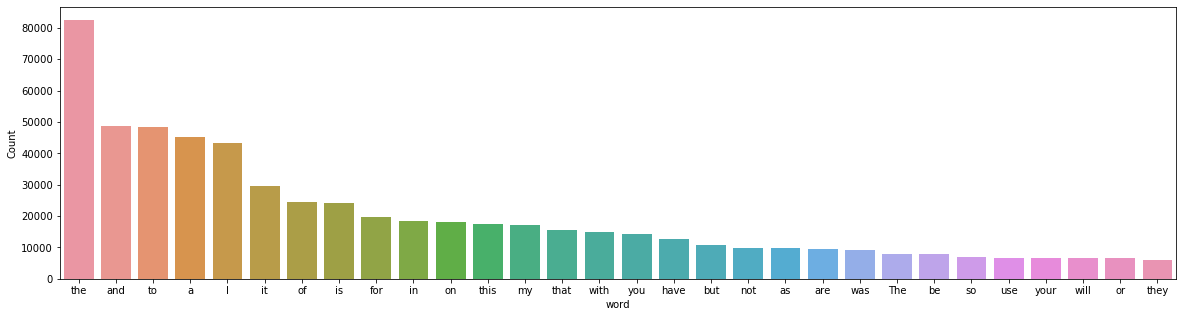

In [5]:
freq_words(df['reviewText'],30)

In [6]:
# remove unwanted characters, numbers and symbols
df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")

In [7]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [8]:
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['reviewText']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

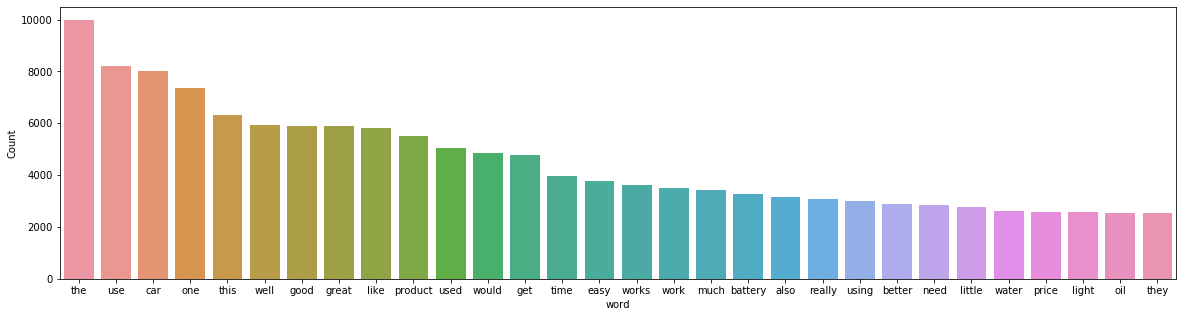

In [9]:
freq_words(reviews, 30)

In [10]:
!python -m spacy download en_core_web_sm 

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2021-12-11 17:37:38.876056: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-12-11 17:37:38.876155: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [12]:

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [13]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['these', 'long', 'cables', 'work', 'fine', 'truck', 'quality', 'seems', 'little', 'shabby', 'side', 'for', 'money', 'expecting', 'dollar', 'snap', 'jumper', 'cables', 'seem', 'like', 'would', 'see', 'chinese', 'knock', 'shop', 'like', 'harbor', 'freight', 'bucks']


In [14]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

['long', 'cable', 'fine', 'truck', 'quality', 'little', 'shabby', 'side', 'money', 'dollar', 'jumper', 'cable', 'chinese', 'shop', 'harbor', 'freight', 'buck']


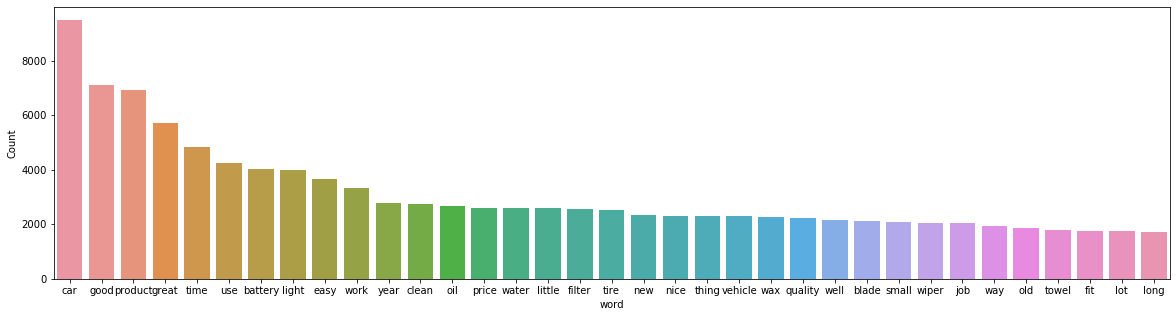

In [20]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))


df['reviews'] = reviews_3

freq_words(df['reviews'], 35)

In [21]:
dictionary = corpora.Dictionary(reviews_2)

In [36]:
print(dictionary)
print(len(dictionary))
print(dictionary[1])

Dictionary(16635 unique tokens: ['brand', 'bumper', 'car', 'close', 'complaint']...)
16635
bumper


In [37]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [40]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [41]:
lda_model.print_topics()

[(0,
  '0.037*"battery" + 0.028*"car" + 0.018*"power" + 0.014*"device" + 0.014*"light" + 0.014*"unit" + 0.010*"charger" + 0.010*"use" + 0.010*"time" + 0.009*"phone"'),
 (1,
  '0.023*"blade" + 0.021*"wiper" + 0.012*"side" + 0.010*"easy" + 0.009*"windshield" + 0.008*"trailer" + 0.008*"great" + 0.008*"time" + 0.007*"fit" + 0.007*"work"'),
 (2,
  '0.034*"oil" + 0.025*"filter" + 0.019*"car" + 0.017*"engine" + 0.014*"change" + 0.011*"inverter" + 0.011*"product" + 0.010*"mile" + 0.009*"gas" + 0.009*"good"'),
 (3,
  '0.020*"plug" + 0.016*"socket" + 0.014*"warm" + 0.013*"cool" + 0.013*"hot" + 0.013*"heat" + 0.013*"cold" + 0.010*"volt" + 0.009*"yellow" + 0.009*"mirror"'),
 (4,
  '0.036*"tire" + 0.025*"hose" + 0.016*"pressure" + 0.015*"water" + 0.013*"gauge" + 0.013*"tool" + 0.013*"good" + 0.013*"air" + 0.012*"use" + 0.009*"easy"'),
 (5,
  '0.039*"car" + 0.029*"product" + 0.018*"towel" + 0.017*"good" + 0.016*"clean" + 0.013*"wax" + 0.013*"water" + 0.013*"great" + 0.011*"time" + 0.011*"leather"'),

In [43]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.092164 -0.017766       1        1  26.021100
1     -0.073097  0.159418       2        1  19.924864
0     -0.051513 -0.053487       3        1  14.817674
4     -0.079800  0.185443       4        1  12.307332
6     -0.098667 -0.041593       5        1  11.352078
2     -0.050068 -0.244811       6        1  10.481611
3      0.445309  0.012795       7        1   5.095341, topic_info=             Term         Freq        Total Category  logprob  loglift
140         light  4957.000000  4957.000000  Default  30.0000  30.0000
34        battery  2975.000000  2975.000000  Default  29.0000  29.0000
324          tire  2410.000000  2410.000000  Default  28.0000  28.0000
2             car  9425.000000  9425.000000  Default  27.0000  27.0000
160           oil  1946.000000  1946.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
193   temperature   187.130074   279.548086   Topic7  -4.9972   2.5755
2027      project   128.480158   163.876965   Topic7  -5.3732   2.7335
2166          eye   133.508254   191.848216   Topic7  -5.3348   2.6143
533         clear   162.036077  1012.475291   Topic7  -5.1412   1.1445
935   application   129.627562   703.220993   Topic7  -5.3643   1.2858

[418 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
1644       6  0.996745  acceleration
1159       3  0.994899      accurate
2797       2  0.269400       adapter
2797       3  0.728761       adapter
2096       2  0.995559      adhesive
...      ...       ...           ...
258        5  0.172356          year
258        6  0.170239          year
1508       1  0.172727        yellow
1508       7  0.827788        yellow
16433      3  0.995302         zubie

[639 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 1, 5, 7, 3, 4])

In [44]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews_2, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
#perplexity lower
#coherence higher great model


Perplexity:  -7.549095764438724

Coherence Score:  0.4631579092956487


In [45]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [46]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=reviews_2, start=2, limit=50, step=1)


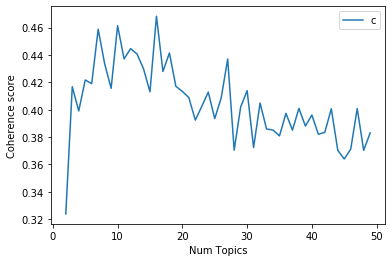

In [47]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [48]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3238
Num Topics = 3  has Coherence Value of 0.4168
Num Topics = 4  has Coherence Value of 0.3991
Num Topics = 5  has Coherence Value of 0.4218
Num Topics = 6  has Coherence Value of 0.4191
Num Topics = 7  has Coherence Value of 0.4588
Num Topics = 8  has Coherence Value of 0.4336
Num Topics = 9  has Coherence Value of 0.4156
Num Topics = 10  has Coherence Value of 0.4615
Num Topics = 11  has Coherence Value of 0.4372
Num Topics = 12  has Coherence Value of 0.4446
Num Topics = 13  has Coherence Value of 0.4407
Num Topics = 14  has Coherence Value of 0.43
Num Topics = 15  has Coherence Value of 0.4131
Num Topics = 16  has Coherence Value of 0.4683
Num Topics = 17  has Coherence Value of 0.428
Num Topics = 18  has Coherence Value of 0.4415
Num Topics = 19  has Coherence Value of 0.4171
Num Topics = 20  has Coherence Value of 0.4134
Num Topics = 21  has Coherence Value of 0.4089
Num Topics = 22  has Coherence Value of 0.3924
Num Topics = 23  has Coh

In [54]:
import os
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME':r'C:/Users/kartik.sonaghela/Documents/mallet-2.0.8/'}) 
#You should update this path as per the path of Mallet directory on your system.
mallet_path = r'C:/Users/kartik.sonaghela/Documents/mallet-2.0.8/bin/mallet' 
#You should update this path as per the path of Mallet directory on your system.

In [55]:
#mallet_path = r'C:\Users\kartik.sonaghela\Documents\mallet-2.0.8\bin\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=7, id2word=dictionary)

In [57]:
print(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=reviews_2, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0, [('oil', 0.038537649318946716), ('price', 0.03761320795597348), ('filter', 0.0368043217633719), ('good', 0.031041007641085642), ('amazon', 0.02172437202987101), ('quality', 0.01897993673354422), ('engine', 0.016307723418699717), ('cheap', 0.014863283789054037), ('change', 0.01412661957793474), ('high', 0.013592176914965838)]), (1, [('car', 0.10149430583898361), ('product', 0.07949443749588572), ('wax', 0.029872951089460864), ('time', 0.019327233230202093), ('paint', 0.017971167138437234), ('wash', 0.016957408992166415), ('good', 0.016904746231321176), ('black', 0.0162332960305444), ('kit', 0.012968204858139688), ('pad', 0.012797050885392666)]), (2, [('clean', 0.038245000970685304), ('water', 0.03599855783897717), ('great', 0.031020328923648668), ('good', 0.028246942341292953), ('towel', 0.024613805918406968), ('job', 0.023851124608259146), ('wheel', 0.021355076684139003), ('leather', 0.0178606095903708), ('dry', 0.01263277588263028), ('product', 0.012272235626924036)]), (3, [('bat

In [60]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [61]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=reviews_2, start=2, limit=40, step=6)

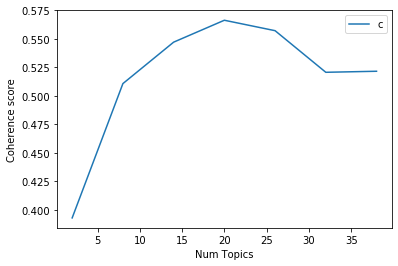

In [62]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [63]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.393
Num Topics = 8  has Coherence Value of 0.5108
Num Topics = 14  has Coherence Value of 0.5472
Num Topics = 20  has Coherence Value of 0.5664
Num Topics = 26  has Coherence Value of 0.5573
Num Topics = 32  has Coherence Value of 0.5208
Num Topics = 38  has Coherence Value of 0.5217


In [72]:
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]
# Select the model and print the topics
model_topics = optimal_model.show_topics(formatted=False)
print(f'''The {x[best_result_index]} topics gives the highest coherence score \\
of {coherence_values[best_result_index]}''')

The 20 topics gives the highest coherence score \
of 0.5664412415168563


In [74]:
def convertldaGenToldaMallet(mallet_model):
    model_gensim = LDA(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

optimal_model = convertldaGenToldaMallet(optimal_model)

In [81]:
#Creating Topic Distance Visualization 

pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(optimal_model, doc_term_matrix, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
3     -0.125966  0.126869       1        1  5.870109
19    -0.138685 -0.083369       2        1  5.574266
6      0.285243  0.080244       3        1  5.525807
18     0.188611  0.104737       4        1  5.289441
16    -0.089293  0.061838       5        1  5.209197
13     0.055507  0.092637       6        1  5.177022
0      0.328081  0.006240       7        1  5.076165
15     0.185588 -0.167193       8        1  5.072323
5     -0.100882 -0.169841       9        1  5.038881
12    -0.059292  0.114311      10        1  4.897605
7     -0.110663  0.170548      11        1  4.897048
4     -0.055385 -0.205347      12        1  4.894510
11    -0.099249 -0.178410      13        1  4.840248
8     -0.086830 -0.082582      14        1  4.796265
9     -0.059865 -0.018099      15        1  4.783696
2     -0.054286  0.138753      16        1  4.723267
17     0.048043 -0.146678      17        1  4.694834
10    -0.039945  0.118756      18        1  4.667073
1     -0.099883  0.150532      19        1  4.644463
14     0.029151 -0.113945      20        1  4.327779, topic_info=        Term          Freq         Total Category  logprob  loglift
2        car  10272.000000  10272.000000  Default  30.0000  30.0000
8      great   6196.000000   6196.000000  Default  29.0000  29.0000
305  product   7431.000000   7431.000000  Default  28.0000  28.0000
140    light   4304.000000   4304.000000  Default  27.0000  27.0000
34   battery   4067.000000   4067.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
841     deal    174.269085    440.181784  Topic20  -4.9051   2.2135
7       good    641.873107   7691.009581  Topic20  -3.6013   0.6567
439     boat    111.488920    230.228136  Topic20  -5.3518   2.4150
608  durable    121.230671    364.759296  Topic20  -5.2680   2.0386
199    trunk    101.747169    298.446399  Topic20  -5.4432   2.0640

[1535 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
76        1  0.993976  absolutley
1345      4  0.976867   absorbant
1290      4  0.987580   absorbent
1290     10  0.011351   absorbent
1291      4  0.999585    absorber
...     ...       ...         ...
654      20  0.987573         yrs
1053     18  1.001762         zip
6704     18  1.000156      zipper
4829     17  0.992807        zone
3472      7  0.999039       zymol

[2283 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 20, 7, 19, 17, 14, 1, 16, 6, 13, 8, 5, 12, 9, 10, 3, 18, 11, 2, 15])